# Enter and process data

This notebook is part of supporting information for "Computational Methods for Regionalized Life Cycle Assessment" by Chris Mutel and Stefanie Hellweg (insert link).

It will not run without an up-to-date installation of the following:
* [brightway2](https://docs.brightwaylca.org/installation.html)
* [brightway2-regional](http://brightway2-regional.readthedocs.org/)

In addition, you need the data directory provided as part of the electronic supporting information.

# Setup

In [1]:
import brightway2 as bw
import bw2regional as bwr
import numpy as np
import pandarus
import xlrd
import os
import json
import csv

In [2]:
bw.projects.set_current("computational methods paper")

In [3]:
bw.create_core_migrations()

Get basic information about this Brightway2 installation

In [3]:
import bw2data, bw2calc, bw2regional, bw2io, pandarus
print("bw2data:", bw2data.__version__)
print("bw2calc:", bw2calc.__version__)
print("bw2regional:", bw2regional.__version__)
print("bw2io:", bw2io.__version__)
print("pandarus:", pandarus.__version__)

bw2data: (3, 4, 2)
bw2calc: (1, 7)
bw2regional: (0, 5)
bw2io: (0, 6)
pandarus: (1, 0, 4)


# Geocollections: `water cfs`, `water-xt`, and `states`

Create geocollections for two new maps:

    * `water cfs`: Gridded spatial scale as defined in `Pfister et al 2009`
    * `water-xt`: Finely detailed raster cells used in extension table for water use
    * `states`: US state boundaries, from national atlas

Here are the CFs given on the `water cfs` spatial scale:

<img src='images/raster-cfs.png'>

In [4]:
water_cfs_vector = pandarus.convert_to_vector(
    pandarus.round_raster(
        pandarus.clean_raster(os.path.abspath(os.path.join("data", 'clipped.tiff')))
    ),
    "output"
)

/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [5]:
water_cfs_vector

'output/956da8c2f7dca5ad8687266eaae0694a08ba7fb7decd794b38a916a430c67f9a.1.geojson'

In [6]:
bwr.geocollections['water cfs'] = {
    'filepath': os.path.abspath(water_cfs_vector),
    'field': "id",
}

In [7]:
bwr.geocollections['states'] = {
    'filepath': os.path.abspath(os.path.join('data', 'state_boundaries.gpkg')),
    'field': 'STATE'
}

## Filter watershed CFs to only include watersheds within the US

This isn't required, but makes the calculations a bit faster, and makes results graphs nicer.

In [8]:
import fiona
from shapely.ops import cascaded_union
from shapely.geometry import shape

states_ds = fiona.open(bwr.geocollections['states']['filepath'])
watersheds_ds = fiona.open(os.path.join("data", "watershed-cfs-all.geojson"))
usa = cascaded_union([shape(obj['geometry']) for obj in states_ds])
good_ws_data = [obj for obj in watersheds_ds if shape(obj['geometry']).intersects(usa)]

In [9]:
schema = watersheds_ds.schema
schema['properties']['name'] = 'str'

with fiona.drivers():
    with fiona.open(
            os.path.join("output", "watershed-cfs.geojson"), 
            'w', 
            driver='GeoJSON', 
            crs=watersheds_ds.crs, 
            schema=watersheds_ds.schema) as f:
        for index, value in enumerate(good_ws_data):
            value['properties']['name'] = "Watershed %s" % index
            f.write(value)

In [10]:
bwr.geocollections['watersheds'] = {
    'filepath': os.path.abspath(os.path.join("output", 'watershed-cfs.geojson')),
    'field': 'name',
}

## Convert extension table inputs from mass to mass per area

The extension table data is not per area - divide each cell by its area to get correct units.

In [11]:
source_fp = os.path.join("data", "blue-water.tiff")
destination_fp = os.path.join("output", 'blue-water-per-area.tiff')

bwr.divide_by_area(source_fp, destination_fp)

/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


We can now point to the correct extension table data.

In [12]:
bwr.geocollections['water-xt'] = {'filepath': os.path.join("output", 'blue-water-per-area.tiff')}

Check to make sure that it worked

In [13]:
sorted(bwr.geocollections)

['states', 'water cfs', 'water-xt', 'watersheds']

# Biosphere database

Download, if necessary, and add surface and groundwater irrigation flows (requires internet connection).

In [8]:
if "biosphere3" not in bw.databases:
    bw.create_default_biosphere3()

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applied 2 strategies in 0.00 seconds


Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 06/15/2018 13:51:29
  Finished: 06/15/2018 13:51:29
  Total time elapsed: 00:00:00
  CPU %: 100.40
  Memory %: 0.51
Created database: biosphere3


In [9]:
biosphere = bw.Database("biosphere3")

In [10]:
data = [
    {
        'code': 'water, irrigation, surface',
        'name': 'Surfacewater irrigation',
        'unit': 'kg',
        'type': 'biosphere',
    }, {
        'code': 'water, irrigation, groundwater',                                               
        'name': 'Groundwater irrigation',
        'unit': 'kg',
        'type': 'biosphere'
    }
]

for ds in data:
    biosphere.new_activity(**ds).save()

# New Intersections: `("water cfs", "states")` and `("states", "water cfs")`

Create new Intersection object that maps state boundaries to LCIA CF raster cells

In [22]:
pandarus_result = pandarus.intersect(
    bwr.geocollections['water cfs']['filepath'],
    bwr.geocollections['water cfs']['field'],    
    bwr.geocollections['states']['filepath'],
    bwr.geocollections['states']['field'],
)

In [24]:
bwr.import_from_pandarus(pandarus_result[1])

('water cfs', 'states')

Check to make sure data is reasonable

In [19]:
print(len(bwr.Intersection(('water cfs', 'states')).load()))
[x for x in bwr.Intersection(('water cfs', 'states')).load() if x[0][1] == '978']

4288


[(('water cfs', '978'), ('states', 'Minnesota'), 799929541.7946181),
 (('water cfs', '978'), ('states', 'North Dakota'), 238975614.18112427),
 (('water cfs', '978'), ('states', 'South Dakota'), 1123863471.753729)]

In [20]:
0.799 / 1.14, 0.239 / 0.34, 1.12 / 1.61

(0.7008771929824562, 0.7029411764705882, 0.6956521739130435)

I checked these values independently using QGis. The areas are not the same, due to a difference in projections, but the actual values don't matter - we only use the relative values, and they are quite close.

<img src="images/intersection-tests.png" width="300">

Pandarus | Manual | Ratio
--- | --- | ---
0.799 | 1.14 | 0.701
0.239 | 0.34 | 0.703
1.12 | 1.61 | 0.696

## Add intersection of `water cfs` and `states` as new geocollection

We can save some work by breaking things down to the smallest possible spatial units - the actual polygons that are the intersections between the spatial units of `water cfs` and `states`.

In [14]:
bwr.remote.calculate_intersection("water cfs", "states")

Calculation job submitted.


In [15]:
bwr.remote.intersection_as_new_geocollection("water cfs", "states", "states to water cfs")

# New Intersections: `('water-xt', 'watersheds')` and `('watersheds', 'water-xt')`

Create new Intersection object that maps extension table spatial units to IA watersheds. The easiest way to do this is to use the `Pandarus` web service.

In [ ]:
bwr.rem

In [21]:
bwr.geocollections

Geocollections dictionary with 4 object(s):
	states
	water cfs
	water-xt
	watersheds

In [17]:
fp = os.path.join(DATA_DIR, "input", "xtable-watershed.json.bz2")
pandarus_result = pandarus.intersect(
    bwr.geocollections['water-xt']['filepath'],
    bwr.geocollections['water-xt']['field'],    
    bwr.geocollections['states']['filepath'],
    bwr.geocollections['states']['field'],
)
intersection = Intersection(('water-xt', 'watersheds'))
intersection.import_from_pandarus(fp)

/Users/cmutel/local/bw2reg/lib/python2.7/site-packages/bw2data/data_store.py:45: UserWarning: 
	Brightway2 Intersection: water-xt: watersheds is not registered
  warnings.warn(u"\n\t%s is not registered" % self, UserWarning)


Check data reasonableness:

In [18]:
intersection.load()[:2]

[(('water-xt', u'Cell(-97.2083335, 36.9583335)'),
  ('watersheds', u'Watershed 165'),
  68764260.49062793),
 (('water-xt', u'Cell(-121.2083335, 37.125)'),
  ('watersheds', u'Watershed 229'),
  68614289.9369457)]

Check also reversed intersection data:

In [19]:
Intersection(('watersheds', 'water-xt')).load()[:2]

[(('watersheds', u'Watershed 165'),
  ('water-xt', u'Cell(-97.2083335, 36.9583335)'),
  68764260.49062793),
 (('watersheds', u'Watershed 229'),
  ('water-xt', u'Cell(-121.2083335, 37.125)'),
  68614289.9369457)]

# New Intersections: `('water-xt', 'states')` and `('states', 'water-xt')`

Create new Intersection object that maps extension table spatial units to states.

In [20]:
fp = os.path.join(DATA_DIR, "input", "xtable-states.json.bz2")
intersection = Intersection(('water-xt', 'states'))
intersection.import_from_pandarus(fp)

/Users/cmutel/local/bw2reg/lib/python2.7/site-packages/bw2data/data_store.py:45: UserWarning: 
	Brightway2 Intersection: water-xt: states is not registered
  warnings.warn(u"\n\t%s is not registered" % self, UserWarning)


Check data reasonableness:

In [21]:
intersection.load()[:2]

[(('water-xt', u'Cell(-91.5416665, 31.375)'),
  ('states', u'Louisiana'),
  38002929.79055291),
 (('water-xt', u'Cell(-102.0416665, 31.7083335)'),
  ('states', u'Texas'),
  73210013.70498723)]

Check also reversed intersection data:

In [22]:
Intersection(('states', 'water-xt')).load()[:2]

[(('states', u'Louisiana'),
  ('water-xt', u'Cell(-91.5416665, 31.375)'),
  38002929.79055291),
 (('states', u'Texas'),
  ('water-xt', u'Cell(-102.0416665, 31.7083335)'),
  73210013.70498723)]

# New LCIA Method: `('irrigation water', 'surface', 'grid scale')`

Create regionalized LCIA method. Start by creating and registering a new Method object.

In [50]:
m_name = ('irrigation water', 'surface', 'grid scale')
m = bw.Method(m_name)
if m_name not in bw.methods:
    m.register(description="Water consumption CFs from Pfister et al 2009", unit="PDF m2 / yr")

This little piece of magic will look at the spatial data file given as metadata for the Method, and import the specified band or layer as CFs for the given flow.

In [51]:
from bw2regional.utils import import_regionalized_cfs

import_regionalized_cfs(
    geocollection="water cfs", 
    method=bw.Method(m_name), 
    # "val" is the default field label when converted to a vector
    mapping={"val": [('biosphere3', 'water, irrigation, surface')]},
    scaling_factor = 1/1000 # Convert from m3 to kg
) 

Check to make sure results are reasonable

In [52]:
bw.Method(m_name).load()[:5]

[(('biosphere3', 'water, irrigation, surface'),
  3.310000151395798e-05,
  ('water cfs', '0')),
 (('biosphere3', 'water, irrigation, surface'),
  4.919999837875366e-05,
  ('water cfs', '1')),
 (('biosphere3', 'water, irrigation, surface'),
  6.049999967217446e-05,
  ('water cfs', '2')),
 (('biosphere3', 'water, irrigation, surface'),
  6.279999762773513e-05,
  ('water cfs', '3')),
 (('biosphere3', 'water, irrigation, surface'),
  6.830000132322311e-05,
  ('water cfs', '4'))]

# New LCIA Method: `('irrigation water', 'surface', 'state scale')`

Create another regionalized LCIA method, at the scale of the inventory.

In [45]:
m_name = ('irrigation water', 'surface', 'state scale')
m = bw.Method(m_name)
if m_name not in bw.methods:
    m.register(
        description="Water consumption CFs from Pfister et al 2009", 
        unit="PDF m2 / yr", 
        geocollections=['states']
    )

In [46]:
wb = xlrd.open_workbook(os.path.join("data", "State_level EI99 CF.xlsx"))
sheet = wb.sheet_by_name("US state level")

In [47]:
state_cf_data = [(
         ('biosphere3', 'water, irrigation, surface'),
         sheet.row(x)[4].value / 1000.,  # Convert m3 to kg
         ('states', sheet.row(x)[1].value)) for x in range(2, sheet.nrows)
        ]

m.write(state_cf_data)

state_cf_data[:3]

[(('biosphere3', 'water, irrigation, surface'),
  7.988954605613223e-05,
  ('states', 'Alabama')),
 (('biosphere3', 'water, irrigation, surface'),
  8.250855732985951e-05,
  ('states', 'Aleutian Is.')),
 (('biosphere3', 'water, irrigation, surface'),
  0.0014922540788756197,
  ('states', 'Arizona'))]

# New LCIA Method: `('irrigation water', 'surface', 'watershed scale')`

CFs on a watershed scale.

In [35]:
m_name = ('irrigation water', 'surface', 'watershed scale')
m = bw.Method(m_name)
if m_name not in bw.methods:
    m.register(
               description="Water consumption CFs from Pfister et al 2009", 
               unit="PDF m2 / yr", 
               geocollections=['watersheds'], 
               cf_field='cf'
               )

/Users/cmutel/local/bw2reg/lib/python2.7/site-packages/bw2data/data_store.py:45: UserWarning: 
	Brightway2 Method: irrigation water: surface: watershed scale is not registered
  warnings.warn(u"\n\t%s is not registered" % self, UserWarning)


In [36]:
from bw2regional.utils import import_regionalized_cfs

import_regionalized_cfs("watersheds", Method(m_name), ('biosphere', 'water, irrigation, surface'))

Convert m3 to kg

In [37]:
data = [(line[0], line[1] / 1000., line[2]) for line in m.load()]
m.write(data)
m.process()

# New LCIA Method: `('irrigation water', 'surface', 'site-generic')`

Create a final, site-generic LCIA method.

In [43]:
m_name = ('irrigation water', 'surface', 'site-generic')
m = bw.Method(m_name)
if m_name not in bw.methods:
    m.register(description="Water consumption CFs from Pfister et al 2009", unit="PDF m2 / yr")

In [44]:
m.write([(('biosphere3', 'water, irrigation, surface'), 0.310016 / 1000.)])
m.load()

[(('biosphere3', 'water, irrigation, surface'), 0.00031001600000000004)]

# New extension table: `blue water consumption`

In [7]:
stats_output = pandarus.raster_statistics(
    bwr.geocollections['states to water cfs']['filepath'],
    bwr.geocollections['states to water cfs']['field'],    
    bwr.geocollections['water-xt']['filepath']
)

/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/pandarus/rasters.py:177: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/Users/cmutel/miniconda3/envs/regional/lib/python3.6/site-packages/pandarus/rasters.py:204: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(fsrc.array.dtype, float) and \


In [15]:
bwr.pandarus.import_xt_from_rasterstats(
    stats_output, 
    "blue water consumption",
    'states to water cfs'
)

Brightway2 ExtensionTable: blue water consumption

Check that values are reasonable

In [16]:
bwr.ExtensionTable("blue water consumption").load()[:4]

[(9.143180250248406e-06, ('states to water cfs', 2064)),
 (1.7596825273358263e-05, ('states to water cfs', 2065)),
 (1.960679583135061e-05, ('states to water cfs', 2066)),
 (7.830067261238582e-06, ('states to water cfs', 2185))]

# New Loading: `irrigation water surface withdrawals`

In [21]:
l_name = ('irrigation water surface withdrawals')
loading = bwr.Loading(l_name)
if l_name not in bwr.loadings:
    loading.register(unit="MGal/day/km^2")

In [23]:
loading_data = json.load(open(os.path.join("output", "loading.json")))

# Add geocollection id to loading data
loading_data = [[x[0], ('water cfs', x[1])] for x in loading_data]
loading.validate(loading_data)
loading.write(loading_data)

loading_data[0]

[96.96912132466527, ('water cfs', 'Cell(-80.75, 27.75)')]

# New LCI database: `crops`

We use the LCI datasets for the US from the LCA Data Commons; specifically, version 1 prepared in Ecospold version 1 format, and available from https://data.nal.usda.gov/dataset/unit-process-data-field-crop-production-version-1/resource/31ee2655-a96b-4d16-82d7-48e53575a501. This data is public domain.

We have filtered these datasets to the crops of interest in the case study, and use only data for the year 2000.

In the code repository, these files are compressed to save space. You should unzip `data/crops.zip`.

In [4]:
if "crops" in bw.databases:
    del bw.databases['crops']

importer = bw.SingleOutputEcospold1Importer(os.path.join("data", "crops"), "crops")

Extracting XML data from 63 datasets
Extracted 63 datasets in 0.58 seconds


In [5]:
importer.apply_strategies()

Applying strategy: normalize_units
Applying strategy: assign_only_product_as_production
Applying strategy: clean_integer_codes
Applying strategy: drop_unspecified_subcategories
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: update_ecoinvent_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: link_technosphere_by_activity_hash
Applied 11 strategies in 0.82 seconds


In [6]:
importer.match_database(fields=['name', 'location'])

Applying strategy: link_iterable_by_fields


In [7]:
importer.statistics()

63 datasets
40141 exchanges
40078 unlinked exchanges
  Type biosphere: 1743 unique unlinked exchanges
  Type production: 92 unique unlinked exchanges
  Type technosphere: 3802 unique unlinked exchanges


(63, 40141, 40078)

## Cleanup Step 1: Fix state names

Need to go from `AL` to `('states', 'Alabama')` to match the locations in the `'states'` geocollection and the state-level CFs.

In [8]:
state_mapping = {
    'AL': 'ALABAMA',
    'AR': 'ARKANSAS',
    'AZ': 'ARIZONA',
    'CA': 'CALIFORNIA',
    'CO': 'COLORADO',
    'GA': 'GEORGIA',
    'IA': 'IOWA',
    'ID': 'IDAHO',
    'IL': 'ILLINOIS',
    'IN': 'INDIANA',
    'KS': 'KANSAS',
    'KY': 'KENTUCKY',
    'LA': 'LOUISIANA',
    'MI': 'MICHIGAN',
    'MN': 'MINNESOTA',
    'MO': 'MISSOURI',
    'MS': 'MISSISSIPPI',
    'MT': 'MONTANA',
    'NC': 'NORTH CAROLINA',
    'ND': 'NORTH DAKOTA',
    'NE': 'NEBRASKA',
    'NY': 'NEW YORK',
    'OH': 'OHIO',
    'OK': 'OKLAHOMA',
    'OR': 'OREGON',
    'PA': 'PENNSYLVANIA',
    'SD': 'SOUTH DAKOTA',
    'TN': 'TENNESSEE',
    'TX': 'TEXAS',
    'WA': 'WASHINGTON',
    'WI': 'WISCONSIN',
}

In [9]:
for ds in importer.data:
    ds['location'] = ('states', state_mapping[ds['location']].title())

## Cleanup Step 2: Make dataset names simpler

In [10]:
name_mapping = {
    r'corn grain; at harvest in 2000; at farm; 85%-91% moisture': 'corn',
    r'cotton lint; at harvest in 2000; at farm; 90%-93% moisture': 'cotton',
    r'soybeans; at harvest in 2000; at farm; 85%-92% moisture': 'soybeans',
    r'winter wheat; at harvest in 2000; at farm; 86%-90% moisture': 'winter wheat'
}

In [11]:
for ds in importer.data:
    ds['name'] = name_mapping[ds['name']]
    
    for exc in ds['exchanges']:
        if exc['name'] in name_mapping:
            exc['name'] = name_mapping[exc['name']]

## Cleanup Step 3: Change `from unspec. source` irrigation to surface water

This is a conservative assumption, and we don't have any better guesses.

We also clean up the names by removing the products.

In [12]:
{exc['name'] for ds in importer.data for exc in ds['exchanges'] if 'water; withdrawal' in exc['name']}

{'water; withdrawal from groundwater, for corn, in 2000',
 'water; withdrawal from groundwater, for cotton, in 2000',
 'water; withdrawal from groundwater, for soybeans, in 2000',
 'water; withdrawal from groundwater, for winter wheat, in 2000',
 'water; withdrawal from surface water, for corn, in 2000',
 'water; withdrawal from surface water, for cotton, in 2000',
 'water; withdrawal from surface water, for soybeans, in 2000',
 'water; withdrawal from surface water, for winter wheat, in 2000',
 'water; withdrawal from unspec. source, for corn, in 2000',
 'water; withdrawal from unspec. source, for cotton, in 2000',
 'water; withdrawal from unspec. source, for soybeans, in 2000',
 'water; withdrawal from unspec. source, for winter wheat, in 2000'}

In [13]:
for ds in importer.data:
    for exc in ds['exchanges']:
        if exc['name'].startswith('water; withdrawal from unspec. source'):
            exc['name'] = 'water; withdrawal from surface water' 
        elif exc['name'].startswith('water; withdrawal from surface water'):
            exc['name'] = 'water; withdrawal from surface water' 
        elif exc['name'].startswith('water; withdrawal from groundwater'):
            exc['name'] = 'water; withdrawal from groundwater' 

## Cleanup Step 4: Link irrigation water to biosphere flows

In [14]:
for ds in importer.data:
    for exc in ds['exchanges']:
        if exc['name'] == 'water; withdrawal from surface water':
            exc['input'] = ("biosphere3", 'water, irrigation, surface')
        elif exc['name'] == 'water; withdrawal from groundwater':
            exc['input'] = ("biosphere3", 'water, irrigation, groundwater')

## Internal linking and write database

In [15]:
importer.drop_unlinked(True)

Applying strategy: drop_unlinked
Applied 1 strategies in 0.01 seconds


In [16]:
importer.write_database()

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 08/16/2018 14:17:42
  Finished: 08/16/2018 14:17:42
  Total time elapsed: 00:00:00
  CPU %: 112.40
  Memory %: 0.60
Created database: crops


Brightway2 SQLiteBackend: crops

In [17]:
[ds for ds in bw.Database("crops")]

['corn' (kilogram, ('states', 'Kentucky'), ['agricultural production', 'plant production']),
 'soybeans' (kilogram, ('states', 'Minnesota'), ['agricultural production', 'plant production']),
 'cotton' (kilogram, ('states', 'North Carolina'), ['agricultural production', 'plant production']),
 'corn' (kilogram, ('states', 'Michigan'), ['agricultural production', 'plant production']),
 'winter wheat' (kilogram, ('states', 'Idaho'), ['agricultural production', 'plant production']),
 'corn' (kilogram, ('states', 'Minnesota'), ['agricultural production', 'plant production']),
 'winter wheat' (kilogram, ('states', 'Kansas'), ['agricultural production', 'plant production']),
 'winter wheat' (kilogram, ('states', 'Ohio'), ['agricultural production', 'plant production']),
 'winter wheat' (kilogram, ('states', 'South Dakota'), ['agricultural production', 'plant production']),
 'winter wheat' (kilogram, ('states', 'Kentucky'), ['agricultural production', 'plant production']),
 'soybeans' (kilogram

## Create weighted national production mixes database

Still need to create the mixes for each crop production, with weights from state crop production (normalized to sum to one).

In [22]:
def to_dict(row):
    return {
            'crop': row[2],
            'state': row[0],
            'production': int(row[3].replace(",", ""))
            }

with open(os.path.join("data", "state-production.csv"), "r") as f:
    reader = csv.reader(f)
    next(reader)
    production_data = [to_dict(x) for x in reader if x[2] != 'Spring Wheat']
    
production_data[:3]

[{'crop': 'Soybeans', 'production': 2880000, 'state': 'ALABAMA'},
 {'crop': 'Soybeans', 'production': 80325000, 'state': 'ARKANSAS'},
 {'crop': 'Soybeans', 'production': 9159000, 'state': 'DELAWARE'}]

In [27]:
for crop in ('Corn', 'Cotton', 'Soybeans', 'Winter Wheat'):
    inputs = {ds['location'][1]: ds for ds in importer.data if ds['name'] == crop.lower()}
    productions = {line['state'].title(): line for line in production_data if line['crop'] == crop}
    total = sum([o['production'] for o in productions.values()])
    mapped_total = sum([o['production'] for k, o in productions.items() if k in inputs])
    print("For crop", crop, "found this fraction of national production:", mapped_total / total)

For crop Corn found this fraction of national production: 0.9489784772665315
For crop Cotton found this fraction of national production: 0.9458468842177528
For crop Soybeans found this fraction of national production: 0.9623016088853111
For crop Winter Wheat found this fraction of national production: 0.8408149204436383


It is not great, but not so bad - in any case, it will have to do, as we don't have any additional LCI data.

For whatever reason, the [USDA LCA commons](http://lcacommons.gov) website has data for winter wheat for Michigan, but only 2004 and 2009.

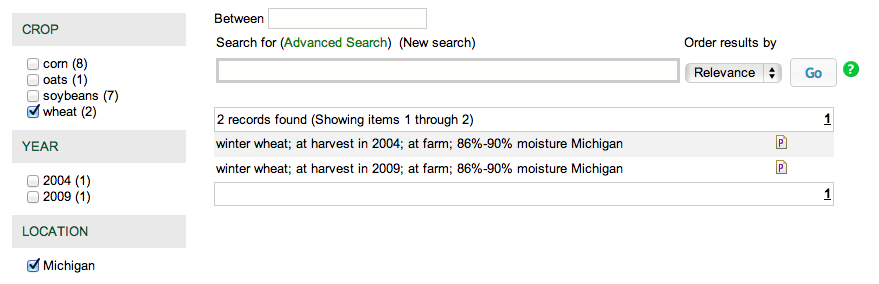

In [65]:
Image(filename='images/lca-commons.png')

In [29]:
mix_db = bw.Database("production mixes")
if "production mixes" not in bw.databases:
    mix_db.register(depends=["crops"], geocollections=['states'])

In [34]:
data = {}

for crop in ('Corn', 'Cotton', 'Soybeans', 'Winter Wheat'):
    inputs = {ds['location'][1]: ds for ds in importer.data if ds['name'] == crop.lower()}
    productions = {line['state'].title(): line for line in production_data if line['crop'] == crop}
    total = sum([o['production'] for k, o in productions.items() if k in inputs])

    exchanges = [{
        'input': ("production mixes", crop),
        'amount': 1,
        'type': 'production',
    }]
    
    for loc, ds in inputs.items():
        if loc not in productions:
            continue
            
        exchanges.append({
            'input': (ds['database'], ds['code']),
            'amount': productions[loc]['production'] / total,
            'type': 'technosphere',
            'location': ds['location']
        })
    
    data[("production mixes", crop)] = {
        'type': 'process',
        'name': crop,
        'location': 'GLO',
        'exchanges': exchanges
    }

In [39]:
mix_db.write(data)

Writing activities to SQLite3 database:
0%  100%
[####] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 08/16/2018 14:41:02
  Finished: 08/16/2018 14:41:02
  Total time elapsed: 00:00:00
  CPU %: 117.60
  Memory %: 0.60


# Set database geocollections

In [42]:
bw.databases["biosphere3"]['geocollections'] = []
bw.databases["crops"]['geocollections'] = ['states']
bw.databases['production mixes']['geocollections'] = ['states']
bw.databases.flush()